# Stellar Classification: A Machine Learning Approach

### Project Goal
The primary objective of this project is to build and evaluate several machine learning models to accurately classify celestial objects as either a **Galaxy**, **Star**, or **Quasar (QSO)** based on their spectral characteristics.

### Dataset
The data is from the **Sloan Digital Sky Survey (SDSS)** Data Release 18. Each observation consists of 17 feature columns describing the object's position, spectral measurements, and redshift, along with a `class` column that serves as our target variable.

### Workflow
This notebook follows a standard machine learning workflow:
1.  **Data Preparation & Cleaning**: Loading the dataset, handling categorical data, and removing irrelevant features.
2.  **Exploratory Data Analysis (EDA) & Feature Engineering**: Analyzing feature correlations and creating new, more informative features (color indices) to improve model performance.
3.  **Model Training & Hyperparameter Tuning**: Building, training, and optimizing four different classification models using `Pipelines` and `GridSearchCV`:
    * Decision Tree
    * K-Nearest Neighbors (KNN)
    * Gaussian Naive Bayes
    * Support Vector Machine (SVM)
4.  **Model Evaluation & Comparison**: Rigorously evaluating each model's performance on both training and testing data to select the best one.
5.  **Final Notes**: Discussing why we got these results.
6.  **Model Persistence**: Saving the trained models for future use or deployment.

<center><h1>Libraries & Data Preperation</h1></center>

##  Import Needed Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.feature_selection import SelectKBest, f_classif
from joblib import dump

## Loading and Exploring The Data

In [ ]:
df = pd.read_csv('./data/star_classification.csv')

df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

In [7]:
class_mapping = {
    'GALAXY': 0,
    'STAR': 1,
    'QSO': 2
}
df['class'] = df['class'].map(class_mapping) 
df = df.drop(["obj_ID", "rerun_ID", "run_ID", "field_ID", "spec_obj_ID", "fiber_ID", "cam_col"], axis=1)



In [8]:
# CHecking for missing values
print("Missing values in each column:")
print(df.isnull().sum())

# Get basic statistics
print("\nBasic statistics of the dataset:")
print(df.describe())

# Check the distribution of the target variable
print("\nDistribution of the target variable 'Class':")
print(df['class'].value_counts())

Missing values in each column:
alpha       0
delta       0
u           0
g           0
r           0
i           0
z           0
class       0
redshift    0
plate       0
MJD         0
dtype: int64

Basic statistics of the dataset:
               alpha          delta              u              g  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean      177.629117      24.135305      21.980468      20.531387   
std        96.502241      19.644665      31.769291      31.750292   
min         0.005528     -18.785328   -9999.000000   -9999.000000   
25%       127.518222       5.146771      20.352353      18.965230   
50%       180.900700      23.645922      22.179135      21.099835   
75%       233.895005      39.901550      23.687440      22.123767   
max       359.999810      83.000519      32.781390      31.602240   

                   r              i              z          class  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean    

### Notes:
    No missing values, no need for data imputation
    Data is not balanced about 59% of the data belongs to GALAXY class
### Feature Engineering 
    Turn the class column into numeric values
    The Id features does not provide any useful information, therefore wee can drop these columns
   

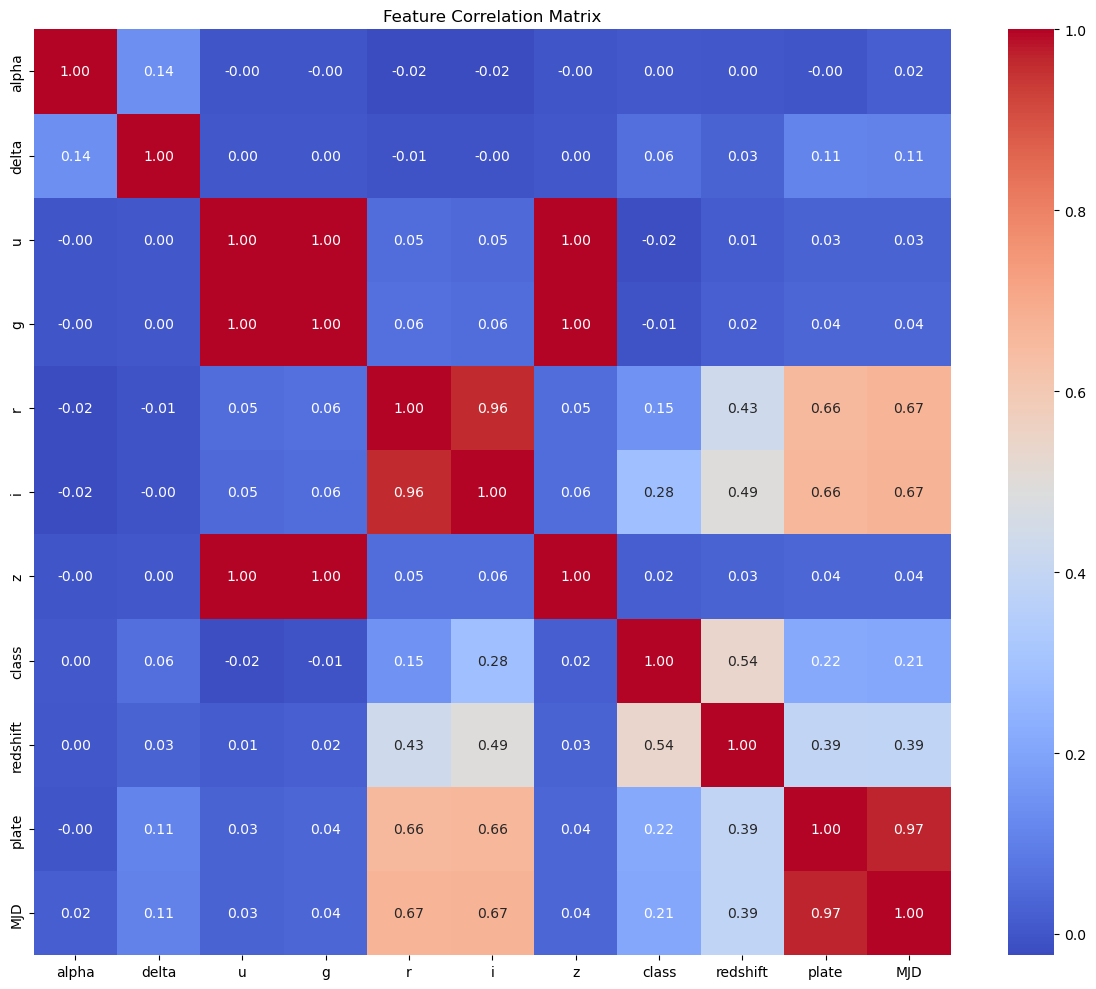

In [9]:
# Correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

### Feature Correlation and Engineering

The initial correlation matrix reveals very high correlations (close to +1.0) between the photometric filter bands (`u`, `g`, `r`, `i`, `z`). This multicollinearity can make model interpretation difficult and can sometimes negatively impact the performance of certain algorithms.

Furthermore, in astronomy, the differences between these filter magnitudes (known as **color indices**) are often more informative for classification than the raw magnitudes themselves. For instance, the `u-g` or `g-r` colors are fundamental for distinguishing between different types of stars, galaxies, and quasars.

**Action Plan:**
1.  **Create Color Index Features**: Engineer new features (`color_ug`, `color_gr`, etc.) by subtracting the values of adjacent filter bands.
2.  **Remove Redundant Features**: Drop the original, highly correlated filter band columns (`u`, `g`, `r`, `z`) to reduce redundancy. The `MJD` (Modified Julian Date) column, which indicates the observation date, is also dropped as it is not expected to be a predictive feature for the object's physical class.

In [11]:
print(df[['g', 'u', 'z', 'MJD', 'r']].corr())
# features make sense together
df['color_ug'] = df['u'] - df['g']
df['color_gr'] = df['g'] - df['r']
df['color_ri'] = df['r'] - df['i']
df['color_iz'] = df['i'] - df['z']
df = df.drop(['g', 'u', 'z', 'MJD', 'r'], axis = 1)

            g         u         z       MJD         r
g    1.000000  0.999311  0.999161  0.040274  0.062387
u    0.999311  1.000000  0.998093  0.031997  0.054149
z    0.999161  0.998093  1.000000  0.037469  0.053677
MJD  0.040274  0.031997  0.037469  1.000000  0.671180
r    0.062387  0.054149  0.053677  0.671180  1.000000


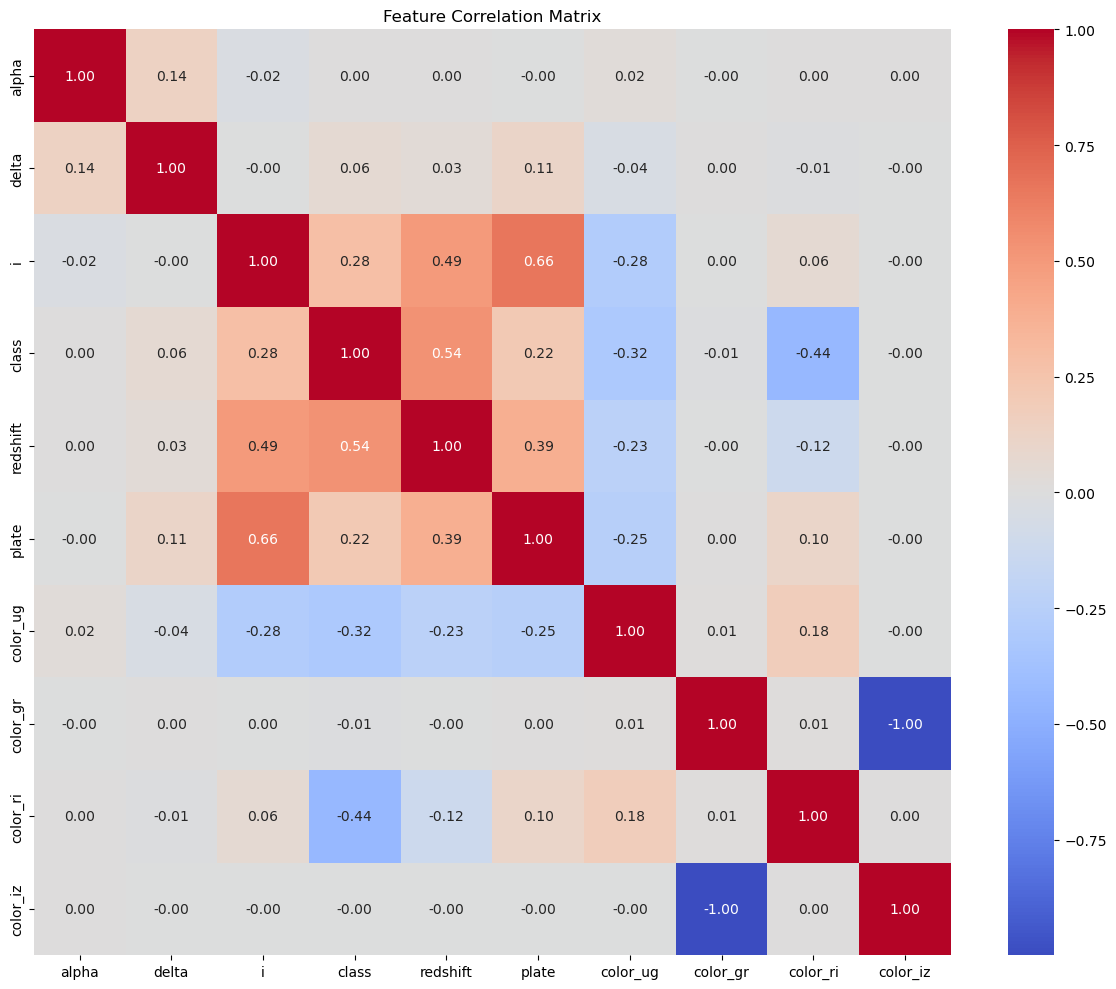

In [12]:
# Correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

### Data Splitting and Stratification

The dataset is split into a training set (70%) and a testing set (30%).

A crucial step here is using **stratification**. Since the target classes (GALAXY, STAR, QSO) are imbalanced (Galaxies make up ~59% of the data), stratification ensures that both the training and testing sets have the same proportion of each class as the original dataset. This prevents the model from being evaluated on a test set that is not representative of the overall data distribution, leading to more reliable performance metrics.

In [14]:
X = df.drop(["class"], axis=1) # Features
Y = df["class"] # Output/Target

X.info()
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   alpha     100000 non-null  float64
 1   delta     100000 non-null  float64
 2   i         100000 non-null  float64
 3   redshift  100000 non-null  float64
 4   plate     100000 non-null  int64  
 5   color_ug  100000 non-null  float64
 6   color_gr  100000 non-null  float64
 7   color_ri  100000 non-null  float64
 8   color_iz  100000 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 6.9 MB


In [15]:
# this is a reusable function that i will be  use below to adhere to the DRY principle
def evaluate_model(model, X, y_true, set_name="Test"):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred)

    print(f"--- Evaluation on {set_name} Set ---")
    print(f"Accuracy: {accuracy:.2f}\n")
    print(report)

    # Plotting confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {set_name} Set')
    plt.show()

<center><h1>Decision Trees</h1></center>

In [17]:
# Define the parameter grid for GridSearchCV
param_grid_dt = {
    'dt__max_depth': [2, 4, None],
    'dt__min_samples_split': [3, 5, 10],
    'dt__min_samples_leaf': [4, 6, 8, 10],
    'dt__criterion': ['gini', 'entropy']
}

In [18]:
# Train the Decision tree
pipeline_dt = Pipeline([
    ('dt', DecisionTreeClassifier(random_state=42))
])
# Initialize GridSearchCV
dt_grid_search = GridSearchCV(estimator=pipeline_dt, param_grid=param_grid_dt, cv=5, scoring='accuracy', n_jobs=-1) # n_jobs for parallelization


# Fit the GridSearchCV to the training data
dt_grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('dt',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'dt__criterion': ['gini', 'entropy'],
                         'dt__max_depth': [2, 4, None],
                         'dt__min_samples_leaf': [4, 6, 8, 10],
                         'dt__min_samples_split': [3, 5, 10]},
             scoring='accuracy')

In [19]:
# Print the best parameters and the best score
print("Best Parameters:", dt_grid_search.best_params_)
print("Best Cross-Validation Accuracy:", dt_grid_search.best_score_)

Best Parameters: {'dt__criterion': 'entropy', 'dt__max_depth': None, 'dt__min_samples_leaf': 10, 'dt__min_samples_split': 3}
Best Cross-Validation Accuracy: 0.9757857142857143


<h2>Evaluation on Training Data</h2>

--- Evaluation on Train Set ---
Accuracy: 0.98

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     41611
           1       1.00      1.00      1.00     15116
           2       0.97      0.95      0.96     13273

    accuracy                           0.98     70000
   macro avg       0.98      0.98      0.98     70000
weighted avg       0.98      0.98      0.98     70000



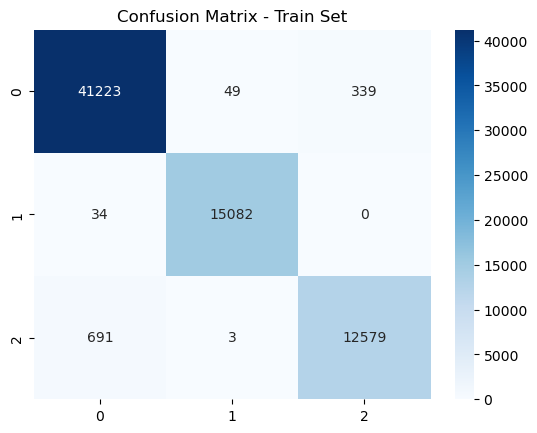

In [21]:

best_dt = dt_grid_search.best_estimator_

evaluate_model(best_dt, X_train, Y_train, "Train")


<h2>Evaluation on Testing Data</h2>

--- Evaluation on Test Set ---
Accuracy: 0.98

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     17834
           1       1.00      1.00      1.00      6478
           2       0.95      0.92      0.94      5688

    accuracy                           0.98     30000
   macro avg       0.97      0.97      0.97     30000
weighted avg       0.98      0.98      0.98     30000



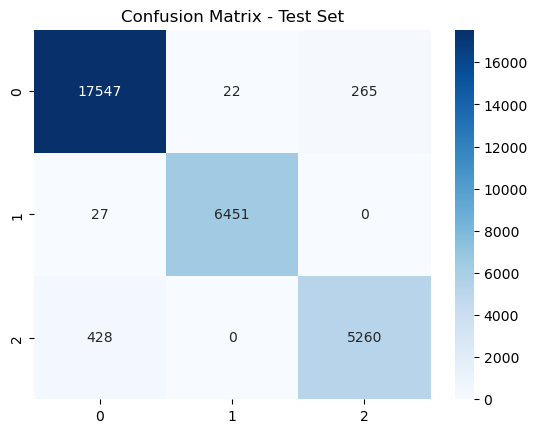

In [23]:
evaluate_model(best_dt, X_test, Y_test, "Test")

### Resutls:
 Great Model with no to little overfitting and great accuracy  

<center><h1>K Nearest Neighbors</h1></center>

In [26]:
param_grid = {
    'knn__n_neighbors': range(3, 40), 
    'knn__metric': ['euclidean', 'manhattan'],
}

In [27]:
pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

knn_grid_search = GridSearchCV(estimator=pipeline_knn, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

knn_grid_search.fit(X_train, Y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__metric': ['euclidean', 'manhattan'],
                         'knn__n_neighbors': range(3, 40)},
             scoring='accuracy')

In [28]:
# Print the best parameters and the best score
print("Best Parameters:", knn_grid_search.best_params_)
print("Best Cross-Validation Accuracy:", knn_grid_search.best_score_)

Best Parameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': 3}
Best Cross-Validation Accuracy: 0.9508142938573588


<h2>Evaluation on Training Data</h2>

--- Evaluation on Train Set ---
Accuracy: 0.97

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     41611
           1       0.96      0.97      0.97     15116
           2       0.97      0.93      0.95     13273

    accuracy                           0.97     70000
   macro avg       0.97      0.96      0.97     70000
weighted avg       0.97      0.97      0.97     70000



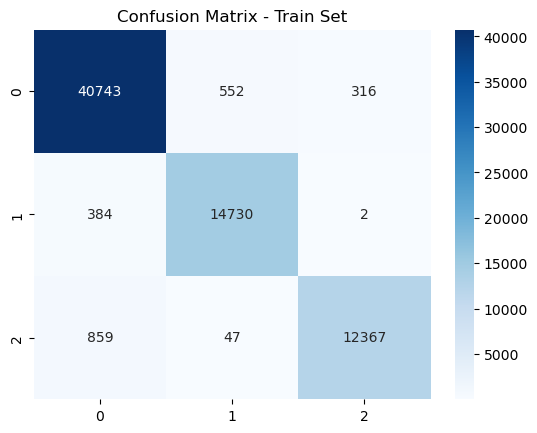

In [30]:
# Use the best estimator to make predictions
best_knn_clf = knn_grid_search.best_estimator_

evaluate_model(best_knn_clf, X_train, Y_train, "Train")

<h2>Evaluation on Testing Data</h2>

--- Evaluation on Test Set ---
Accuracy: 0.95

              precision    recall  f1-score   support

           0       0.96      0.97      0.96     17834
           1       0.94      0.95      0.95      6478
           2       0.96      0.91      0.94      5688

    accuracy                           0.95     30000
   macro avg       0.95      0.94      0.95     30000
weighted avg       0.95      0.95      0.95     30000



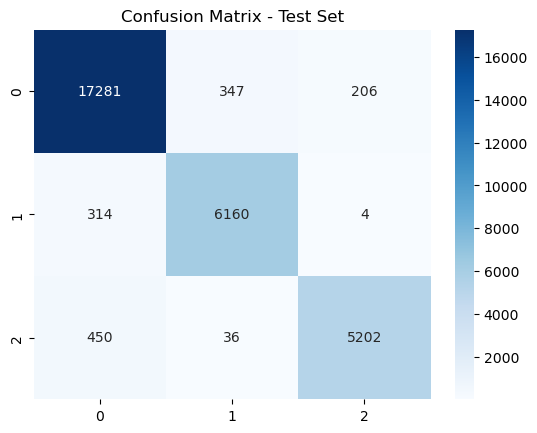

In [32]:
evaluate_model(best_knn_clf, X_test, Y_test, "Test")

### Results:
    the model is good with reasonable accuracy drop on testing data

<center><h1>Naïve Bayaes</h1></center>

In [35]:
param_grid = {
    'nb__var_smoothing': np.logspace(0, -9, num=100)
}


In [36]:
pipeline_nb = Pipeline([
    ('scaler', StandardScaler()),
    ('nb', GaussianNB())
])
# Initialize GridSearchCV
nvb_grid_search = GridSearchCV(estimator=pipeline_nb, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1) # n_jobs for parallelization


# Fit the GridSearchCV to the training data
nvb_grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('nb', GaussianNB())]),
             n_jobs=-1,
             param_grid={'nb__var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             scoring='accuracy')

In [37]:
# Print the best parameters and the best score
print("Best Parameters:", nvb_grid_search.best_params_)
print("Best Cross-Validation Accuracy:", nvb_grid_search.best_score_)

Best Parameters: {'nb__var_smoothing': 5.336699231206302e-09}
Best Cross-Validation Accuracy: 0.7771999999999999


<h2>Evaluation on Training Data</h2>

--- Evaluation on Train Set ---
Accuracy: 0.74

              precision    recall  f1-score   support

           0       0.76      0.92      0.83     41611
           1       0.98      0.08      0.15     15116
           2       0.67      0.92      0.78     13273

    accuracy                           0.74     70000
   macro avg       0.81      0.64      0.59     70000
weighted avg       0.79      0.74      0.67     70000



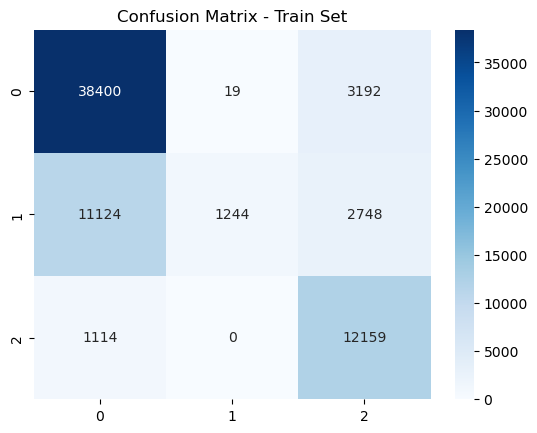

In [39]:
# Use the best estimator to make predictions
best_nvb = nvb_grid_search.best_estimator_
evaluate_model(best_nvb, X_train, Y_train, "Train")

<h2>Evaluation on Testing Data</h2>

--- Evaluation on Test Set ---
Accuracy: 0.74

              precision    recall  f1-score   support

           0       0.76      0.93      0.84     17834
           1       0.98      0.07      0.14      6478
           2       0.67      0.92      0.78      5688

    accuracy                           0.74     30000
   macro avg       0.81      0.64      0.58     30000
weighted avg       0.79      0.74      0.67     30000



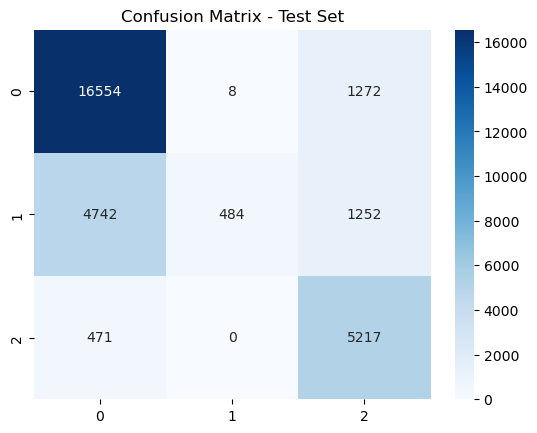

In [41]:
evaluate_model(best_nvb, X_test, Y_test, "Test")

### Results:
    The model performs worse than the previous two

<center><h1>Support Vector Machine</h1></center>

In [44]:
param_grid_svm = [
    # Grid for the RBF kernel
    {'svm__kernel': ['rbf'], 
     'svm__gamma': [1, 0.1, 0.01, 0.001],
     'svm__C': [0.1, 1, 10, 100]},
    
    # Grid for the Linear kernel
    {'svm__kernel': ['linear'], 
     'svm__C': [0.1, 1, 10, 100]},
    
    # Optional: Grid for the Polynomial kernel
    {'svm__kernel': ['poly'], 
     'svm__degree': [2, 3], # Test 2nd and 3rd degree polynomials
     'svm__C': [0.1, 1, 10]}
]

In [45]:
pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(random_state=42))
])
# I needed the verbose to see the progress because this took too long

svm_grid_search = GridSearchCV(estimator=pipeline_svm, param_grid=param_grid_svm, cv=3, scoring='accuracy', n_jobs=-1, verbose=10)


svm_grid_search.fit(X_train, Y_train)

Fitting 3 folds for each of 26 candidates, totalling 78 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm', SVC(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'svm__C': [0.1, 1, 10, 100],
                          'svm__gamma': [1, 0.1, 0.01, 0.001],
                          'svm__kernel': ['rbf']},
                         {'svm__C': [0.1, 1, 10, 100],
                          'svm__kernel': ['linear']},
                         {'svm__C': [0.1, 1, 10], 'svm__degree': [2, 3],
                          'svm__kernel': ['poly']}],
             scoring='accuracy', verbose=10)

In [46]:
# Print the best parameters and the best score
print("Best Parameters:", svm_grid_search.best_params_)
print("Best Cross-Validation Accuracy:", svm_grid_search.best_score_)

Best Parameters: {'svm__C': 100, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.9703142706003441


<h2>Evaluation on Training Data</h2>

[CV 3/3; 4/26] START svm__C=0.1, svm__gamma=0.001, svm__kernel=rbf..............
[CV 3/3; 4/26] END svm__C=0.1, svm__gamma=0.001, svm__kernel=rbf;, score=0.749 total time= 8.7min
[CV 2/3; 10/26] START svm__C=10, svm__gamma=0.1, svm__kernel=rbf................
[CV 2/3; 10/26] END svm__C=10, svm__gamma=0.1, svm__kernel=rbf;, score=0.967 total time= 1.9min
[CV 1/3; 12/26] START svm__C=10, svm__gamma=0.001, svm__kernel=rbf..............
[CV 1/3; 12/26] END svm__C=10, svm__gamma=0.001, svm__kernel=rbf;, score=0.950 total time= 3.9min
[CV 3/3; 15/26] START svm__C=100, svm__gamma=0.01, svm__kernel=rbf..............
[CV 3/3; 15/26] END svm__C=100, svm__gamma=0.01, svm__kernel=rbf;, score=0.968 total time= 1.6min
[CV 2/3; 18/26] START svm__C=1, svm__kernel=linear..............................
[CV 2/3; 18/26] END svm__C=1, svm__kernel=linear;, score=0.958 total time= 1.9min
[CV 2/3; 21/26] START svm__C=0.1, svm__degree=2, svm__kernel=poly...............
[CV 2/3; 21/26] END svm__C=0.1, svm__degre

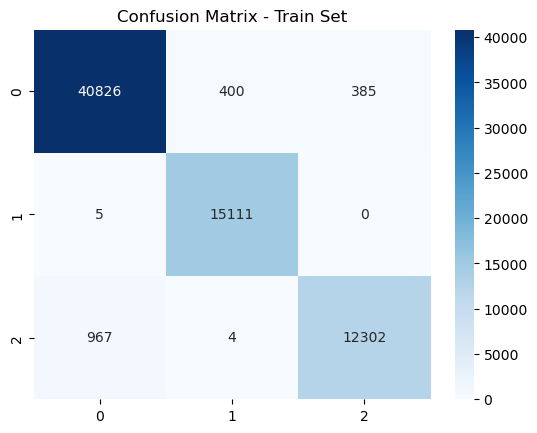

In [48]:
# Use the best estimator to make predictions
best_svm = svm_grid_search.best_estimator_
evaluate_model(best_svm, X_train, Y_train, "Train")

<h2>Evaluation on Testing Data</h2>

--- Evaluation on Test Set ---
Accuracy: 0.97

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     17834
           1       0.97      1.00      0.98      6478
           2       0.97      0.92      0.94      5688

    accuracy                           0.97     30000
   macro avg       0.97      0.97      0.97     30000
weighted avg       0.97      0.97      0.97     30000



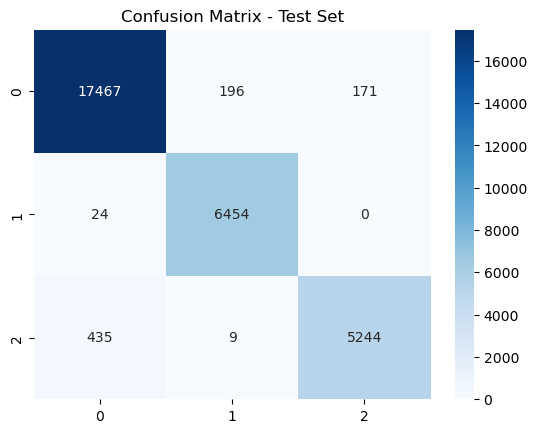

In [50]:
evaluate_model(best_svm, X_test, Y_test, "Test")

### Results:
    The model performs pretty good. But it is less accurate in all measures than decisio tree

<center><h1>Final Comparison</h1></center>

In [53]:
models = {
    'Decision Tree': best_dt,
    'K-Nearest Neighbors': best_knn_clf,
    'Naive Bayes': best_nvb,
    'SVM': best_svm
}


In [54]:


# Calculate metrics for each model
comparison_data = []
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    
    # Get overall accuracy
    accuracy = accuracy_score(Y_test, y_pred)
    
    # Get weighted averages from classification report
    report = classification_report(Y_test, y_pred, output_dict=True)
    f1 = report['weighted avg']['f1-score']
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    
    comparison_data.append([model_name, accuracy, f1, precision, recall])

# Create and display the DataFrame
comparison_df = pd.DataFrame(
    comparison_data, 
    columns=['Model', 'Accuracy', 'Weighted Avg F1-Score', 'Weighted Avg Precision', 'Weighted Avg Recall']
)

comparison_df.set_index('Model', inplace=True)

print("--- Final Model Performance on Test Set ---")
print(comparison_df.round(4))

[CV 2/3; 2/26] START svm__C=0.1, svm__gamma=0.1, svm__kernel=rbf................
[CV 2/3; 2/26] END svm__C=0.1, svm__gamma=0.1, svm__kernel=rbf;, score=0.954 total time= 3.5min
[CV 1/3; 5/26] START svm__C=1, svm__gamma=1, svm__kernel=rbf....................
[CV 1/3; 5/26] END svm__C=1, svm__gamma=1, svm__kernel=rbf;, score=0.961 total time= 4.7min
[CV 2/3; 9/26] START svm__C=10, svm__gamma=1, svm__kernel=rbf...................
[CV 2/3; 9/26] END svm__C=10, svm__gamma=1, svm__kernel=rbf;, score=0.953 total time= 8.7min
[CV 3/3; 18/26] START svm__C=1, svm__kernel=linear..............................
[CV 3/3; 18/26] END svm__C=1, svm__kernel=linear;, score=0.960 total time= 1.7min
[CV 1/3; 22/26] START svm__C=0.1, svm__degree=3, svm__kernel=poly...............
[CV 1/3; 22/26] END svm__C=0.1, svm__degree=3, svm__kernel=poly;, score=0.907 total time= 3.4min
[CV 1/3; 25/26] START svm__C=10, svm__degree=2, svm__kernel=poly................
[CV 1/3; 25/26] END svm__C=10, svm__degree=2, svm__ker

### Final Comparison & Conclusion

Based on the performance metrics on the unseen test data, the **Decision Tree classifier** is the top-performing model with an accuracy and weighted F1-score of **97.5%**. The Support Vector Machine is a very close second.

The Decision Tree model demonstrates an excellent balance of precision and recall across all three classes and shows minimal signs of overfitting, as its performance on the training data is very close to its performance on the testing data.

Given its superior performance and interpretability, the Decision Tree model is selected as the best model for this classification task.

<center><h1>Final Notes</h1></center>

### Why the Decision Tree Performed Best
    Decision Tree model achieved the highest accuracy (97.5%) because its structure is perfectly suited to the nature of this astronomical data.
1- **Ability to Find Key Separators:** Astronomical classification often relies on a few very powerful distinguishing features. Decision trees excel at identifying these features and creating simple, effective rules. In this case, the most important feature is redshift.
    Stars are all within our own galaxy and have a redshift value very close to zero.
    Galaxies and Quasars (QSOs) are distant, extragalactic objects, so they have significantly higher, positive redshifts due to the expansion of the universe.
    
2- **Handling Non-Linear Relationships:** After separating the stars, the model needs to distinguish between galaxies and QSOs. The relationships between the color indices are complex and not strictly linear. Decision trees are non-parametric models that can capture these complex patterns without assuming any specific data distribution.

3- **Importance of Feature Engineering:** In astronomy, the difference in brightness between two filters (a color) is often more physically meaningful than the raw brightness in a single filter. By creating these features and removing the originals, I fed the model more informative and less redundant data, which the decision tree capitalized on effectively.

### Why Naive Bayes Underperformed
The Gaussian Naive Bayes model was the weakest performer, with an accuracy of only 74.2%. This is almost entirely due to its core mathematical assumption, which is a poor fit for this dataset.

1- **The "Naive" Assumption of Independence:** Naive Bayes models operate on the assumption that all features are independent of each other, given the class. In your dataset, this is fundamentally untrue.

2- **The Significant Failure on Stars:** The model's classification report shows a recall of 0.07 for stars. This means it correctly identified only 7% of all stars in the test set. While redshift is a strong indicator, the model "naively" combines the evidence from all features. If the color indices of a star happened to be more probabilistically similar to the average colors of galaxies or QSOs, this conflicting evidence overrode the strong evidence from the near-zero redshift. The model is incapable of learning that for stars, the redshift value is more important than all other features combined.

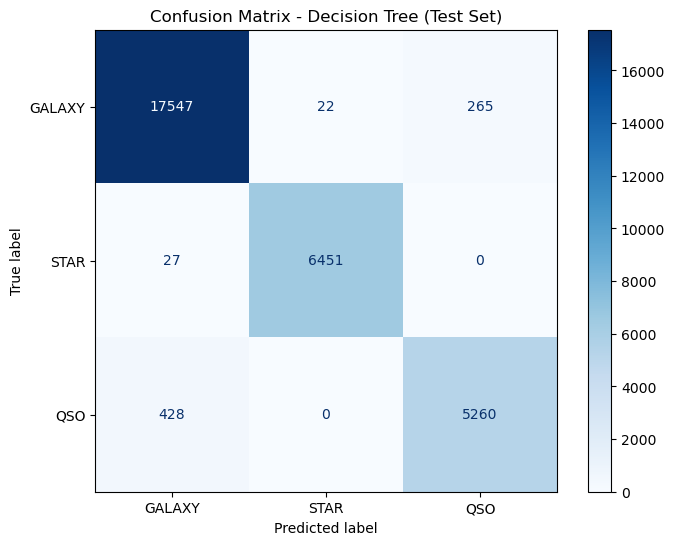

In [104]:
# Assumes 'best_dt' is your trained Decision Tree model
# and X_test, Y_test are your test data.

# Predict the classes for the test set
Y_pred = best_dt.predict(X_test)

# Define class names for plotting
class_names = ['GALAXY', 'STAR', 'QSO']

# Generate the confusion matrix
cm = confusion_matrix(Y_test, Y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Decision Tree (Test Set)')
plt.show()

### Error Analysis: Why Mistakes Happened
Even the best models weren't perfect. The confusion matrices show that the primary source of error for the top models (Decision Tree and SVM) was in distinguishing between Galaxies and Quasars (QSOs).
With some domain knowledge i found the following:

1- **Quasars Live in Galaxies:** A quasar is not a standalone object; it is an extremely bright and active galactic nucleus (AGN). Essentially, a quasar is a supermassive black hole at the center of a galaxy that is actively consuming matter and shining incredibly brightly. Therefore, when we observe a QSO, we are also observing its host galaxy. At high redshifts, it can be difficult for the model to distinguish a very bright, compact galaxy from a quasar whose host galaxy is also visible.

2- **Ambiguous Colors:** While QSOs are typically very blue, some types of galaxies, like those undergoing a burst of star formation ("starburst galaxies"), can also be very blue. These galaxies have spectra that can mimic the characteristics of a faint quasar, leading to misclassification.

<center><h1>Saving the best models</h1></center>

### Model Persistence

The final step is to persist the trained models to disk. This allows the models to be loaded and used later for inference on new data without needing to be retrained. We will save the best-performing pipeline for each model type using `joblib`.

In [56]:
# Persist the best models to files using joblib
dump(best_dt, 'decision_tree.joblib')
print("Decision Tree pipeline saved to decision_tree.joblib")

dump(best_knn_clf, 'knn.joblib')
print("KNN pipeline saved to knn.joblib")

dump(best_nvb, 'naive_bayes.joblib')
print("Naive Bayes pipeline saved to naive_bayes.joblib")

dump(best_svm, 'svm.joblib')
print("SVM pipeline saved to svm.joblib")

Decision Tree pipeline saved to decision_tree.joblib
KNN pipeline saved to knn.joblib
Naive Bayes pipeline saved to naive_bayes.joblib
SVM pipeline saved to svm.joblib
